In [ ]:
!pip install traffic

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


pick which airports to analyse in this runtime

In [111]:
icaolistE=["LTFM","LFPG","EHAM","EDDF","LEMD","EGLL","LIRF","EDDM","LEBL","EGKK"]
markerE='d-'
colorE='peru'
icaolist = icaolistE
countryname = "europa"
markerToUse = markerE
colorToUse = colorE


where to read and save the data (and making sure that the directory exist)

In [112]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = sorted(glob.glob(os.path.join(folder_path, f"*{countryname}.csv")))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_europa.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2024-07-01_2024-10-01_europa.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2024-10-01_2025-01-01_europa.csv']


--------------------------------------------

## Main Part

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - use networkX to get betweenness centrality


In [129]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

csv_file=csv_files[0]

# load all csv files into dataframe

flightdata = pd.concat([pd.read_csv(f, parse_dates=["firstseen", "lastseen", "day"]) for f in csv_files])
#flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
print(csv_file)

#replace origin column name with departure
flightdata.rename(columns={'origin': 'departure'}, inplace=True)
#replace destination column name with arrival
flightdata.rename(columns={'destination': 'arrival'}, inplace=True)

# drop NAN rows if the nan is either in origin or destination
flightdata.dropna(subset=['departure'], inplace=True)
flightdata.dropna(subset=['arrival'], inplace=True)
#flightdata.dropna(inplace=True)
flightdata.describe()

#replace all entries EDDT with EDDB  for account for Berlin-Brandenburg replacing Tegel in 2020
flightdata['departure'] = flightdata['departure'].replace('EDDT', 'EDDB')
flightdata['arrival'] = flightdata['arrival'].replace('EDDT', 'EDDB')

departure_counts = flightdata['departure'].value_counts()
eddm_count = departure_counts.get('EDDM', 0)
eddf_count = departure_counts.get('EDDF', 0)
print(f"at the start: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

#flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
#flightdata = flightdata.rename(columns={"municipality": "departure_city"})
#flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
#flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

# add a column to flightdata dataframe with contains month-and-year
flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')

# query dataframe for everything starting/ending at one of the selected airports
#flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]
#flightdata = flightdata[flightdata['departure'].isin(icaolist)]


/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01_europa.csv
at the start: The departure value 'EDDF' appears 133903 times, and EDDM 104789 times.


In [130]:
flightdata.tail()

,icao24,firstseen,departure,lastseen,arrival,callsign,day,month_and_year
842113,3c675a,2024-12-31 08:35:29+00:00,EDDM,2024-12-31 09:22:56+00:00,EDDB,DLH5T,2024-12-31 00:00:00+00:00,2024-12
842115,4c01e2,2024-12-31 14:47:33+00:00,LTFM,2024-12-31 15:44:25+00:00,LYNI,ASL37G,2024-12-31 00:00:00+00:00,2024-12
842121,801600,2024-12-31 13:40:17+00:00,EGLL,2024-12-31 21:27:42+00:00,VIDP,AIC112,2024-12-31 00:00:00+00:00,2024-12
842122,801600,2024-12-31 02:17:37+00:00,VIDP,2024-12-31 11:28:54+00:00,EGLL,AIC111,2024-12-31 00:00:00+00:00,2024-12
842123,896178,2024-12-31 00:23:28+00:00,OMDB,2024-12-31 07:19:27+00:00,LEBL,UAE81W,2024-12-31 00:00:00+00:00,2024-12


In [131]:
filtered_flightdata = flightdata
#month_year = flightdata['month_and_year'].unique()[0]

# Filter the flightdata for the chosen year_month
#filtered_flightdata = flightdata[flightdata['month_and_year'] == month_year]

#filtered_flightdata.tail()

In [132]:
print(filtered_flightdata.shape)

(2030139, 8)


In [133]:
#departure_counts = filtered_flightdata['departure'].value_counts()
#eddm_count = departure_counts.get('EDDM', 0)
#eddf_count = departure_counts.get('EDDF', 0)
#print(f"after selecting {month_year}: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

# Create a directed graph
weightedgraph = nx.DiGraph()

# Part 1: Add nodes from the flights data
icount=0

filtered_flightdata = filtered_flightdata.reset_index()
for index, row in filtered_flightdata.iterrows():
    origin = row['departure']
    destination = row['arrival']
    icount+=1
    if icount%100000==0:
      print(icount)
    # Add the origin and destination as nodes if they don't exist (and are not identical)
    if origin != destination:
      if origin not in weightedgraph:
          weightedgraph.add_node(origin)
      if destination not in weightedgraph:
          weightedgraph.add_node(destination)
      # add an edge between them if it doesn't exist yet
      if not weightedgraph.has_edge(origin, destination):
          weightedgraph.add_edge(origin, destination)
          #print if this contains eddh and eddf
          if origin== "EDDH" and destination in icaolist:
            print(f'{origin} to {destination}')

print(icount)
nflights= weightedgraph.size(weight="weight")
nroutes=weightedgraph.number_of_edges()
print(f"Number of edges (flight routes): {nroutes}, sum of weights (flights) {nflights}" )
print(list(weightedgraph.degree(['EDDF','EDDM'], weight="weight")))




EDDH to EDDF
EDDH to EGLL
EDDH to EDDM
EDDH to LIRF
EDDH to LEMD
EDDH to LTFM
EDDH to LFPG
EDDH to LEBL
EDDH to EHAM
EDDH to EGKK
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2030139
Number of edges (flight routes): 11891, sum of weights (flights) 11891.0
[('EDDF', 1512), ('EDDM', 1433)]


In [134]:
trafficgraph = nx.Graph()


In [135]:
# Load airport data from your Google Drive
airport_data = pd.read_csv('/content/drive/My Drive/2024KomplexeNetze/Daten/airport-coords.csv', sep=',')

# Create a dictionary to store airport coordinates for faster lookup
airport_coords = {}
for _, row in airport_data.iterrows():
    airport_coords[row['icao']] = (row['latitude'], row['longitude'])

# Function to calculate the distance between two airports using their coordinates
from geopy.distance import geodesic

def calculate_distance(airport1, airport2):
    try:
        coords1 = airport_coords[airport1]
        coords2 = airport_coords[airport2]
        return geodesic(coords1, coords2).km
    except KeyError:
        print(f"Warning: Coordinates not found for {airport1} or {airport2}. Using 0 distance.")
        return 0  # or handle the error as appropriate

# Update edge weights in the weightedgraph
for u, v, data in weightedgraph.edges(data=True):
    distance = calculate_distance(u, v)
    data['weight'] = distance  # Replace weight with distance

print("Edge weights updated with distances.")


Edge weights updated with distances.


In [136]:
# Remove edges with zero weight (=unknown distance)
for u, v, data in list(weightedgraph.edges(data=True)):
    if data['weight'] == 0:
        weightedgraph.remove_edge(u, v)

print("Edges with zero weight removed.")

# sanity check:  print the edge weights between the node EDDH to all airports in icaolist.
for airport in icaolist:
    try:
        weight = weightedgraph['EDDH'][airport]['weight']
        print(f"Edge weight between EDDH and {airport}: {weight}")
    except KeyError:
        print(f"No edge found between EDDH and {airport}")


Edges with zero weight removed.
Edge weight between EDDH and LTFM: 1989.2849616090457
Edge weight between EDDH and LFPG: 729.3989953059175
Edge weight between EDDH and EHAM: 381.6128872074943
Edge weight between EDDH and EDDF: 414.5876611058818
Edge weight between EDDH and LEMD: 1781.3570499286782
Edge weight between EDDH and EGLL: 748.1574011279031
Edge weight between EDDH and LIRF: 1324.8677283213644
Edge weight between EDDH and EDDM: 601.0766451347776
Edge weight between EDDH and LEBL: 1493.8504792753176
Edge weight between EDDH and EGKK: 744.9529340641647


In [137]:
# Betweenness-Zentralität berechnen
#betweenness_centrality = nx.betweenness_centrality(weightedgraph)
#betweenness_centrality = nx.betweenness_centrality(weightedgraph, weight="weight")

# sort the output above
#sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
# Extract airport and centrality data
#airports = [airport for airport, centrality in sorted_betweenness if airport in icaolist]
#centrality_values = [centrality for airport, centrality in sorted_betweenness if airport in icaolist]

#print(sorted_betweenness_centrality)
# Create the plot
#plt.figure(figsize=(10, 6))  # Adjust figure size as needed
#plt.bar(airports, centrality_values, color='skyblue')
#plt.xlabel("Airport")
#plt.ylabel("Betweenness Centrality")
#plt.title("Betweenness Centrality of European Airports")
#plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
#plt.tight_layout()  # Adjust layout to prevent labels from overlapping
#plt.show()


[('EHAM', 0.03182374311633191), ('EDDM', 0.025386493185460095), ('EDDF', 0.02343445482015012), ('LTFM', 0.022723600529038837), ('LFPG', 0.017869844120106476), ('LEMD', 0.016975758494438095), ('EGLL', 0.01616620914357674), ('LEBL', 0.015671692757698214), ('LIRF', 0.011332441607505156), ('EGKK', 0.010179333504349247), ('LROP', 0.0), ('LKPR', 0.0), ('EDDS', 0.0), ('LIPZ', 0.0), ('EGPD', 0.0), ('EGPF', 0.0), ('KJFK', 0.0), ('LEMG', 0.0), ('LPFR', 0.0), ('LPAR', 0.0), ('LBSF', 0.0), ('LPPR', 0.0), ('EDDH', 0.0), ('ESGG', 0.0), ('LBWV', 0.0), ('EKCH', 0.0), ('LOWW', 0.0), ('KATL', 0.0), ('EDDB', 0.0), ('EIDW', 0.0), ('EICK', 0.0), ('CYYC', 0.0), ('LSGG', 0.0), ('LOWG', 0.0), ('EDDL', 0.0), ('OMDB', 0.0), ('EFHK', 0.0), ('EGJJ', 0.0), ('EGPH', 0.0), ('EPKK', 0.0), ('EPWA', 0.0), ('CYYZ', 0.0), ('EDDV', 0.0), ('KIAD', 0.0), ('TJIG', 0.0), ('LFBO', 0.0), ('LFRB', 0.0), ('LFNG', 0.0), ('LFLL', 0.0), ('LFHC', 0.0), ('LFBD', 0.0), ('KMIA', 0.0), ('EGCC', 0.0), ('VIDP', 0.0), ('RJTT', 0.0), ('LCLK'

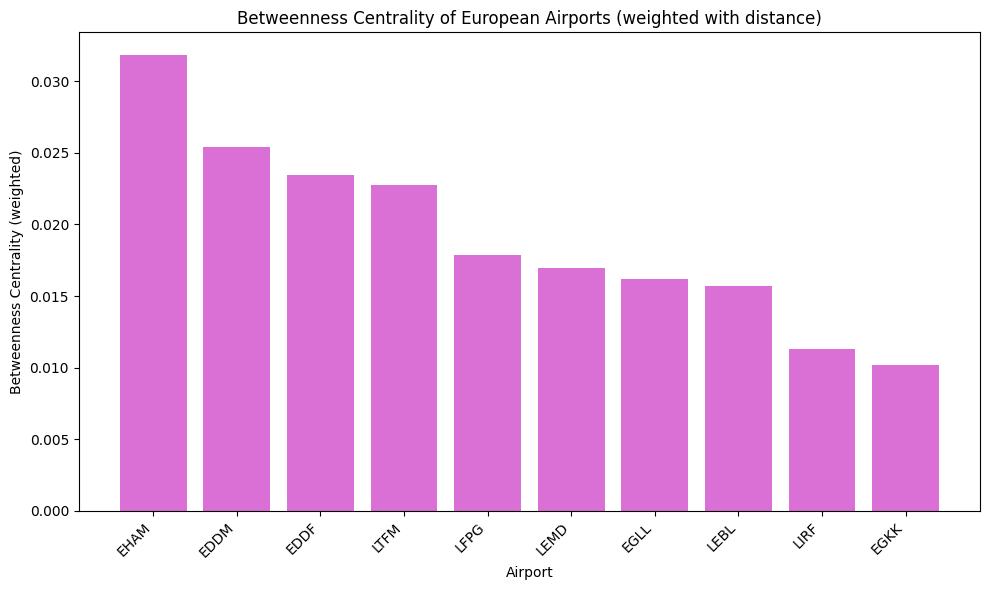

In [138]:
# Betweenness-Zentralität berechnen - mit Gewichten
betweenness_centrality_w = nx.betweenness_centrality(weightedgraph, weight="weight")

# sort the output above
sorted_betweenness_w = sorted(betweenness_centrality_w.items(), key=lambda x: x[1], reverse=True)
# Extract airport and centrality data
airports_w = [airport for airport, centrality in sorted_betweenness_w if airport in icaolist]
centrality_values_w = [centrality for airport, centrality in sorted_betweenness_w if airport in icaolist]

print(sorted_betweenness_w)
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(airports_w, centrality_values_w, color='orchid')
plt.xlabel("Airport")
plt.ylabel("Betweenness Centrality (weighted)")
plt.title("Betweenness Centrality of European Airports (weighted with distance)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


EHAM: 0.4657846715328467
EDDF: 0.43932481751824815
EDDM: 0.42563868613138683
LEMD: 0.4242700729927007
LEBL: 0.4137773722627737
LFPG: 0.35492700729927007
LTFM: 0.312956204379562
LIRF: 0.30474452554744524
EGLL: 0.2855839416058394
EGKK: 0.2760036496350365


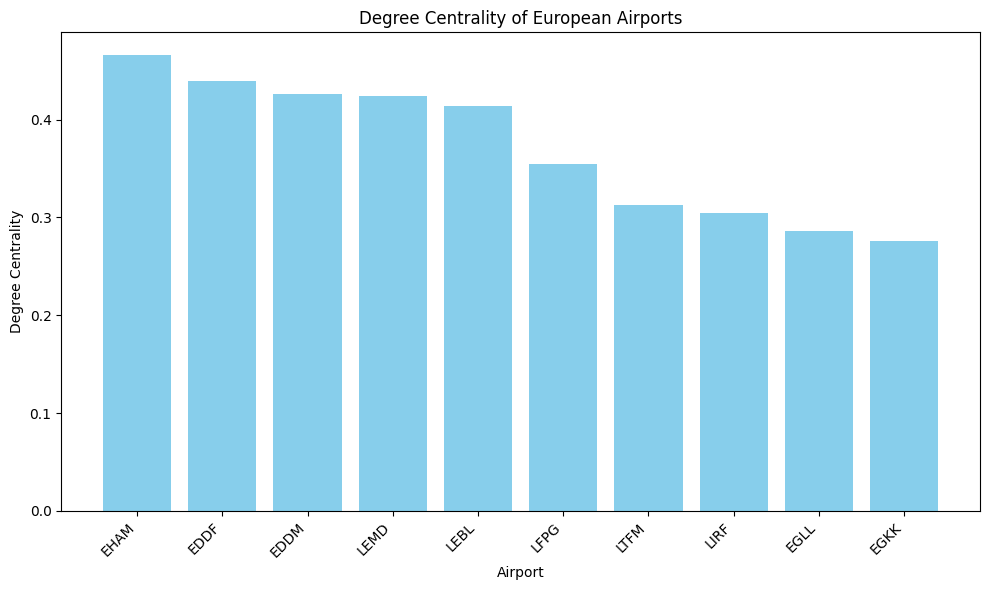

In [139]:
degree_centrality = nx.degree_centrality(weightedgraph)

# Print degree centrality for airports in icaolist, sorted
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

for airport, centrality in sorted_degree:
  if airport in icaolist:
    print(f"{airport}: {centrality}")

# Extract airport and centrality data
airports = [airport for airport, centrality in sorted_degree if airport in icaolist]
centrality_values = [centrality for airport, centrality in sorted_degree if airport in icaolist]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(airports, centrality_values, color='skyblue')
plt.xlabel("Airport")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality of European Airports")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [1]:
# print number of edges that each airport in icaolist has

degree_centrality = nx.degree_centrality(weightedgraph)

for airport in icaolist:
  try:
    print(f"{airport}: {weightedgraph.degree[airport]}")
  except KeyError:
    print(f"{airport}: 0") # Airport not found in the graph


NameError: name 'nx' is not defined